# 1 || Introduction

How we will build the Chatbot?:
</h3>
Chatbots are AI-powered programs that simulate human conversation. They can answer questions, perform tasks, and engage with users, making technology more accessible and efficient. we will walk through this steps:

#Load the data
#EDA and analyze the data for more insights
#Split the data into train, test and validation datasets
#Load BERT Pretrained model and tokenizer
#Transform the data to numerical format
#Train BERT Pretrained model on our custome dataset
#Evaluate the model
#Save the model
#Finally, Load The model and start the conversation

# 2 ||Import Necessaries¶

In [1]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

# 3 || EDA + Vis¶

3.1 || Load the data

In [2]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename ='intents.json'

intents = load_json_file(filename)

# 3.2 || Extract Info from the Json data file and Store it in dataframe# 

In [3]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


In [4]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [5]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


# 3.3 || Check the shape of the dataset# 

In [6]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 405 rows and 2 columns


# 3.4 || Display information about the dataset


In [7]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None


# 3.5 || Display Number of Classes

In [8]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 38 classes


# 3.6 || Check the null values in the dataset

In [9]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")
    

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


# 3.7 || Visualize the Null Values

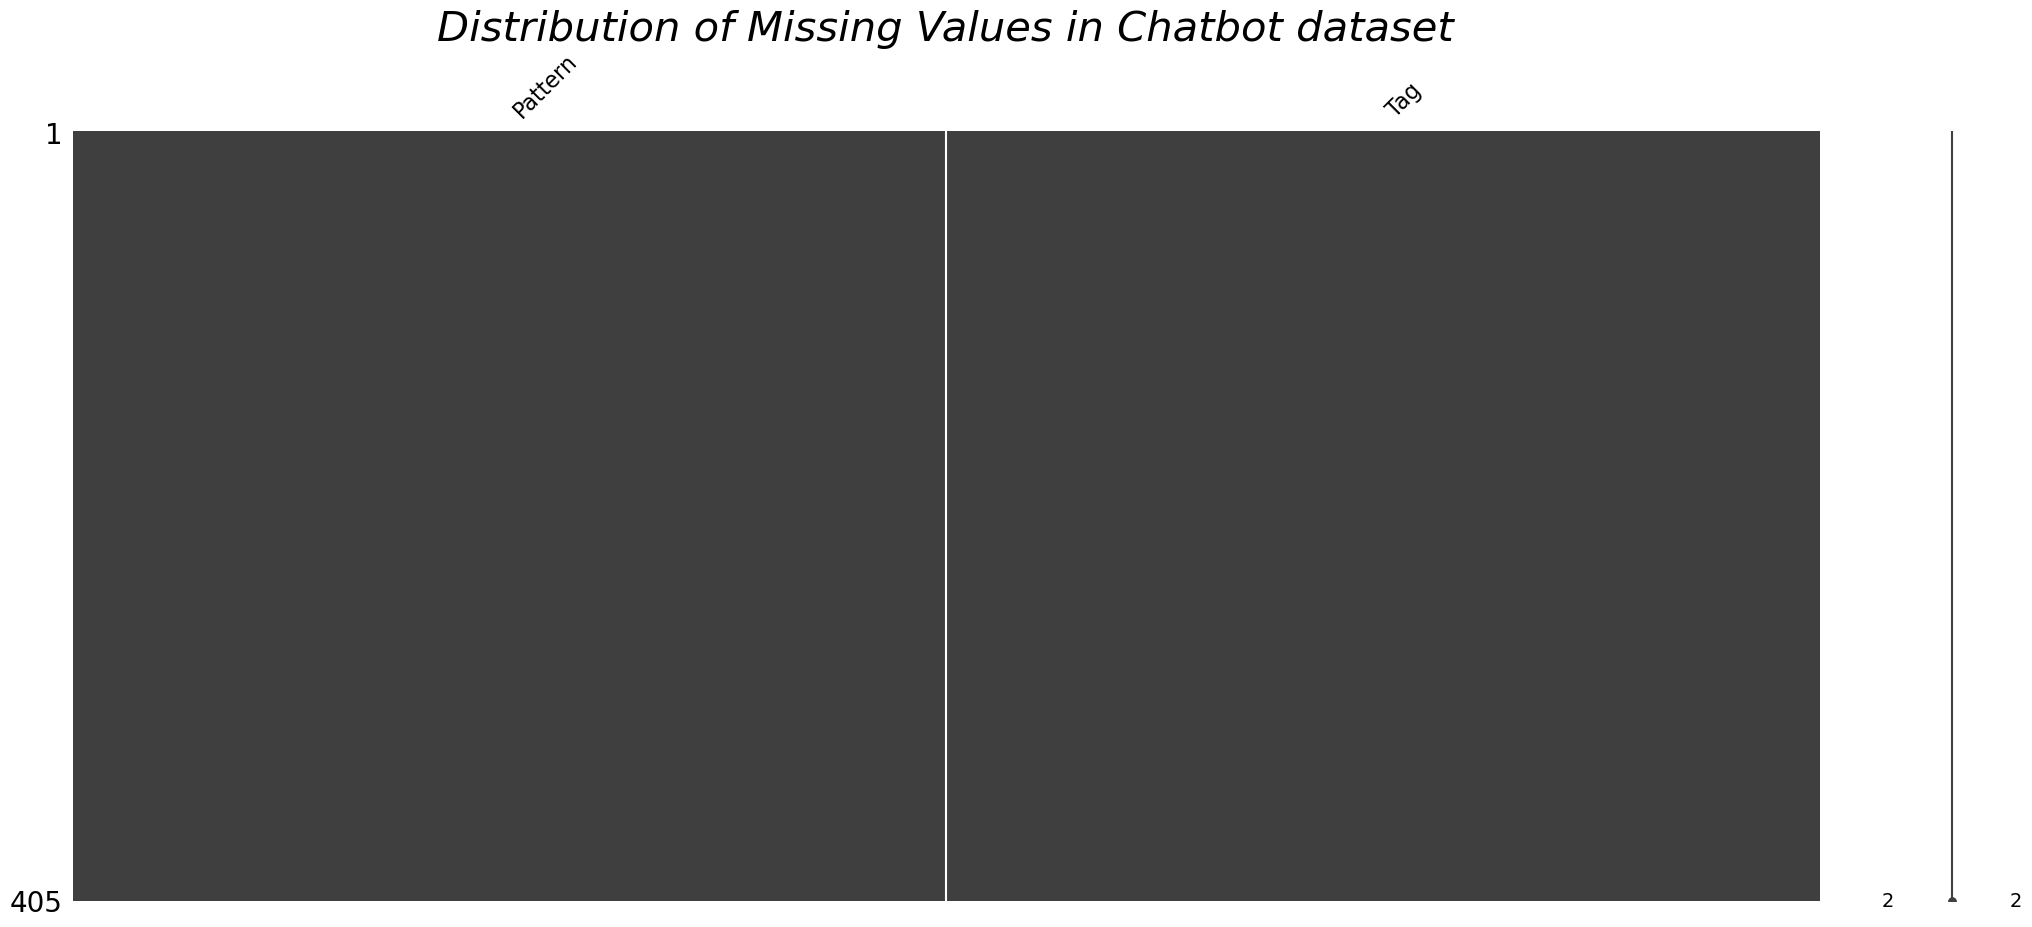

In [10]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()
    
plot_miss_vals(df, "Chatbot")

# 3.8 || Visualize the distrbution of our Classes

In [11]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

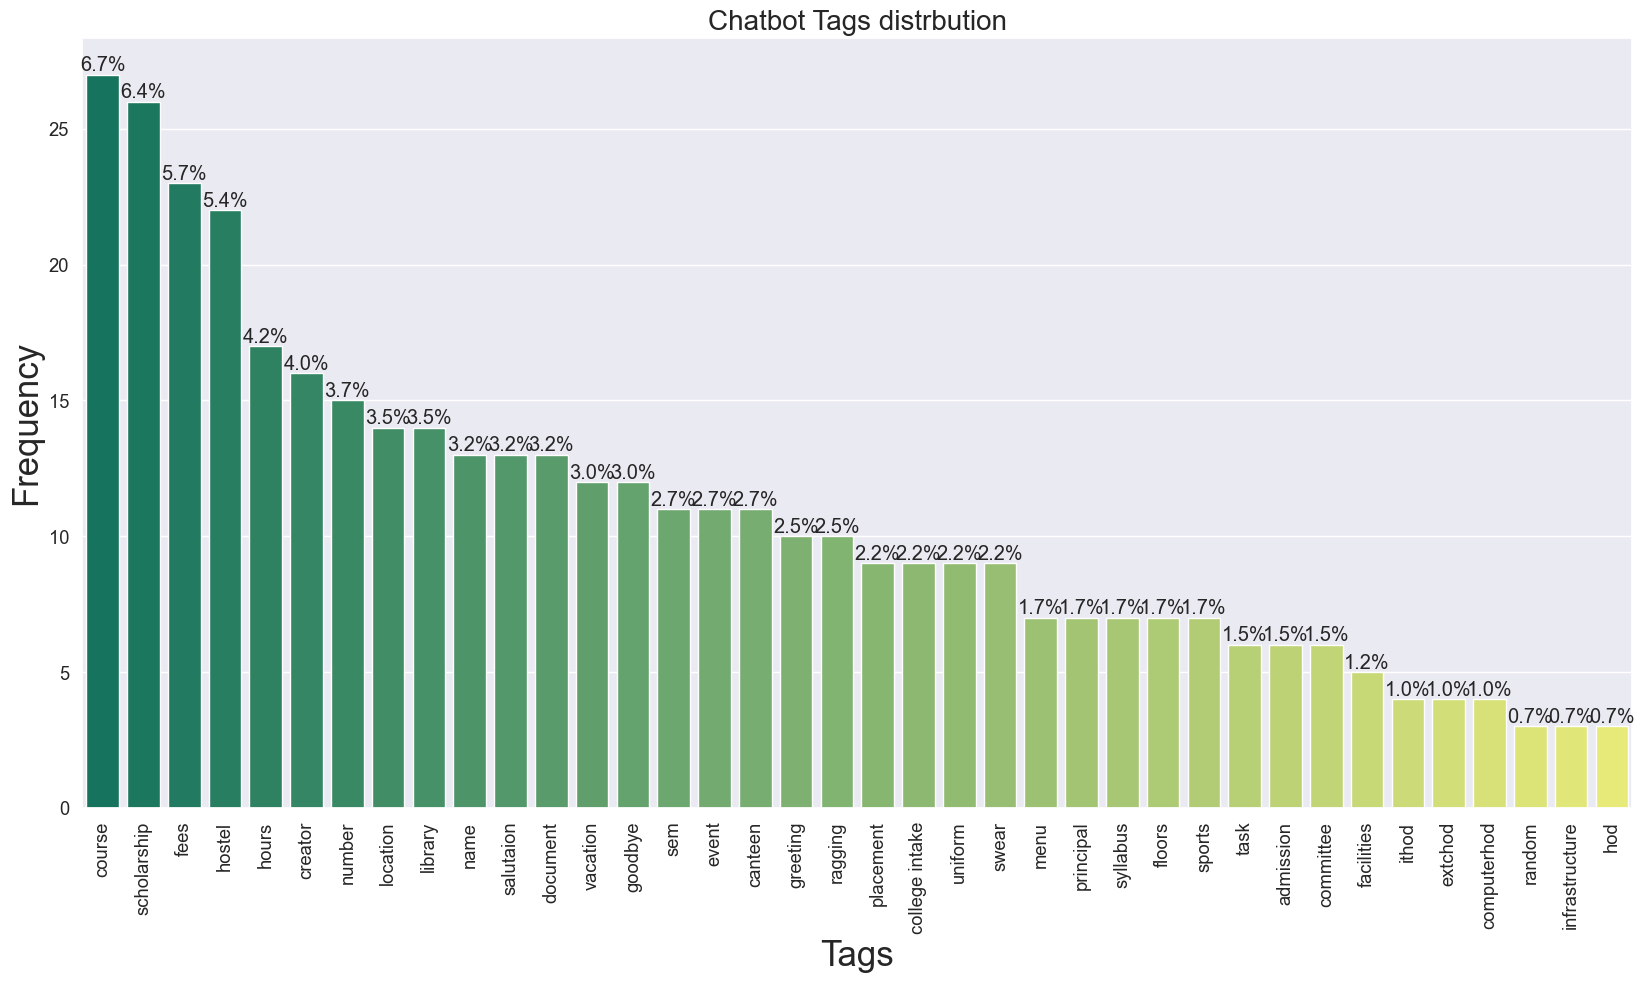

In [12]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [13]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [14]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [15]:
print(df['Pattern'].isnull().sum())

0


# 3.9 || Display Word Cloud

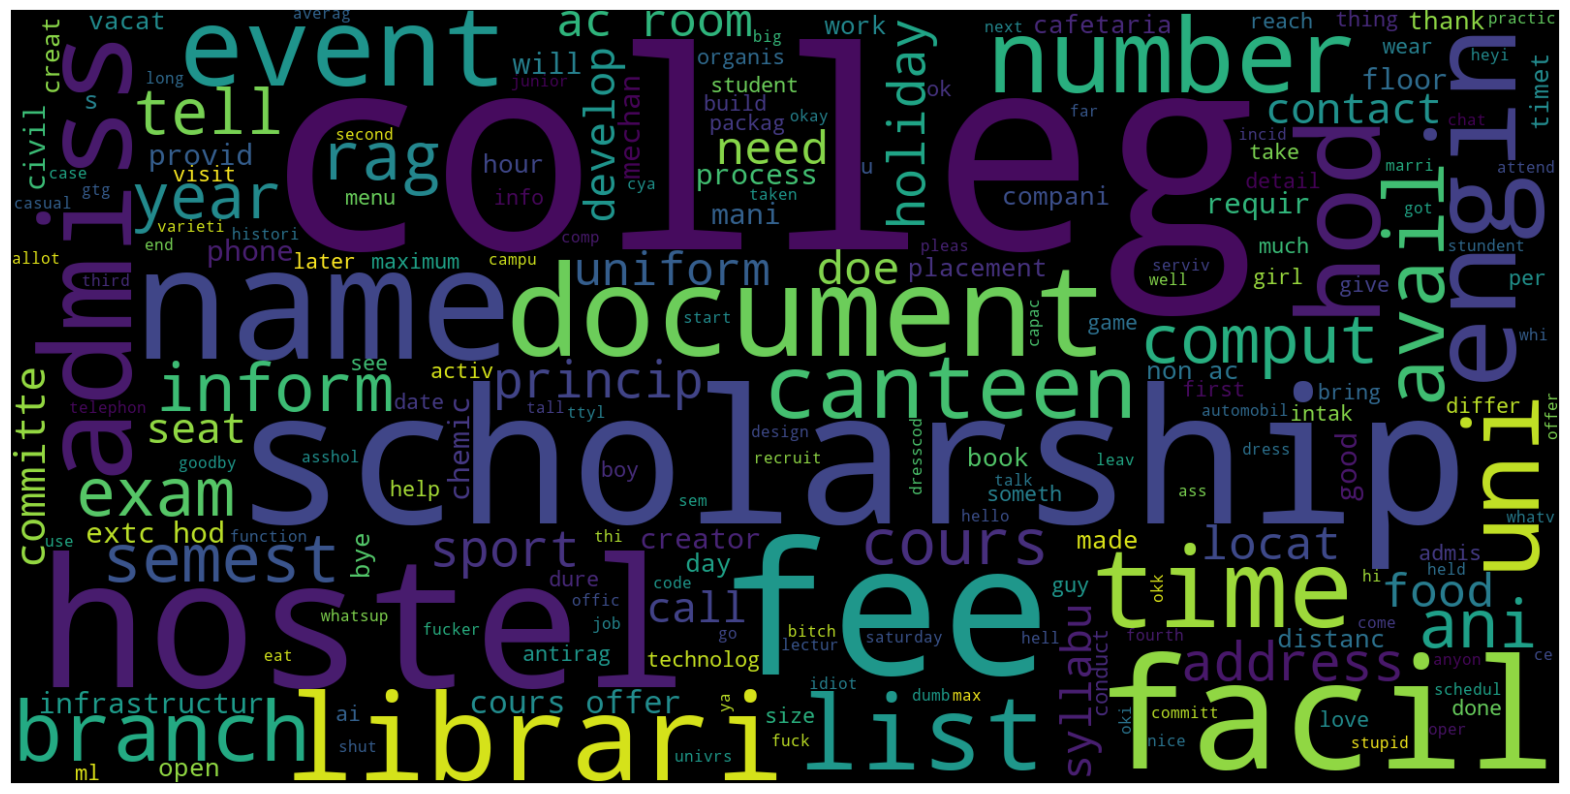

In [16]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

# 3.10 || Distrbution of Number of letters in each text

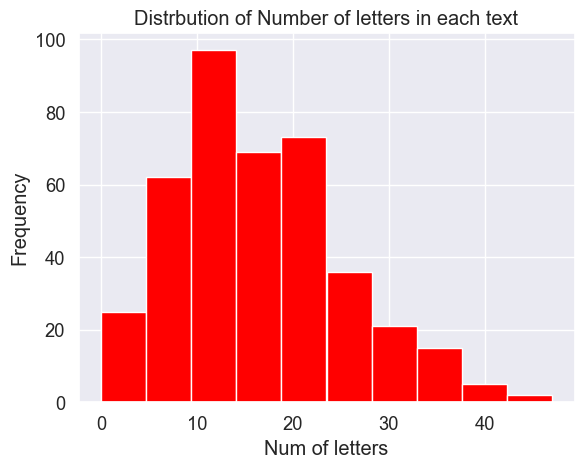

In [17]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

# 3.11 || Distrbution of Number of words in each text

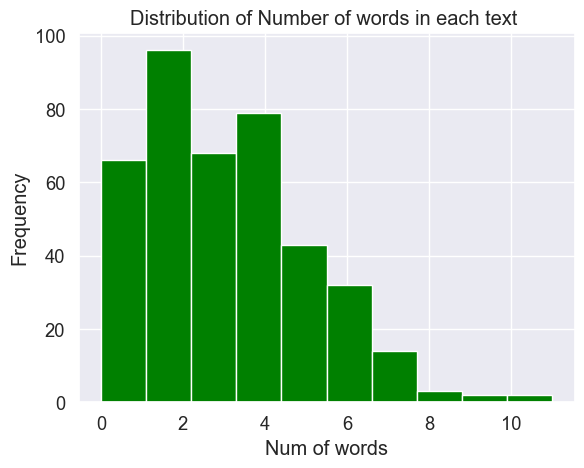

In [18]:
words_len=df['Pattern'].str.split().map(lambda x : len(x))
plt.hist(words_len,color='green')
plt.title('Distribution of Number of words in each text ')
plt.xlabel('Num of words')
plt.ylabel('Frequency')
plt.show()

# 3.12 || Visualize Average word length in each text

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\NIKHIL JAIN\AppData\Local\Temp\ipykernel_4184\3636871129.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color= 'red')


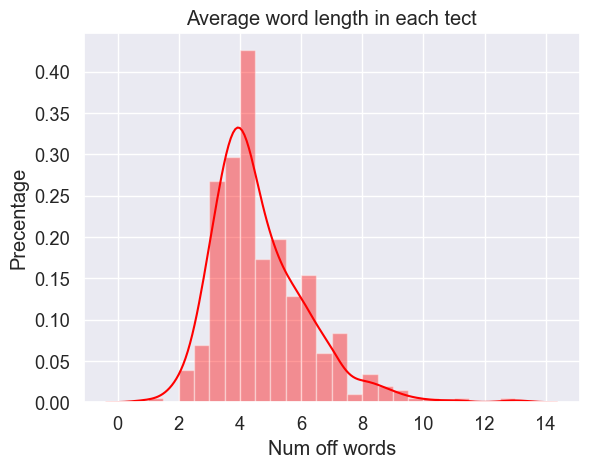

In [19]:
word= df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x : np.mean(x))
sns.distplot(word,color= 'red')
plt.title('Average word length in each tect')
plt.xlabel('Num off words')
plt.ylabel('Precentage')
plt.show()

# 3.13 || Visualize top words

In [20]:
# a = pd.DataFrame({'paaa':['OpenAI is OpenAI','OpenAI ',' an American is artificial intelligence'],'index':[1,2,3]})

In [21]:
# a['paaa']

In [22]:
def get_corpus(series):
    words=[]
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words       
corpus=get_corpus(df.Pattern)
corpus[:10]

['hi', 'how', 'are', 'you', 'is', 'anyon', 'there', 'hello', 'good', 'day']

In [23]:
print(f'dataset contains {len(corpus)} words')

dataset contains 1345 words


In [25]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'is': 75,
 'colleg': 71,
 'what': 59,
 'the': 46,
 'you': 35,
 'of': 33,
 'in': 29,
 'for': 26,
 'scholarship': 26,
 'are': 25}

In [36]:
df.Pattern

0                  hi
1         how are you
2      is anyon there
3               hello
4            good day
            ...      
400       rag histori
401         rag incid
402               hod
403          hod name
404    who is the hod
Name: Pattern, Length: 405, dtype: object

In [37]:
def get_top_text_ngrams(corpus,n,g):
    vec=CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words =bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq,key= lambda x: x[1],reverse= True)
    return words_freq[:n]

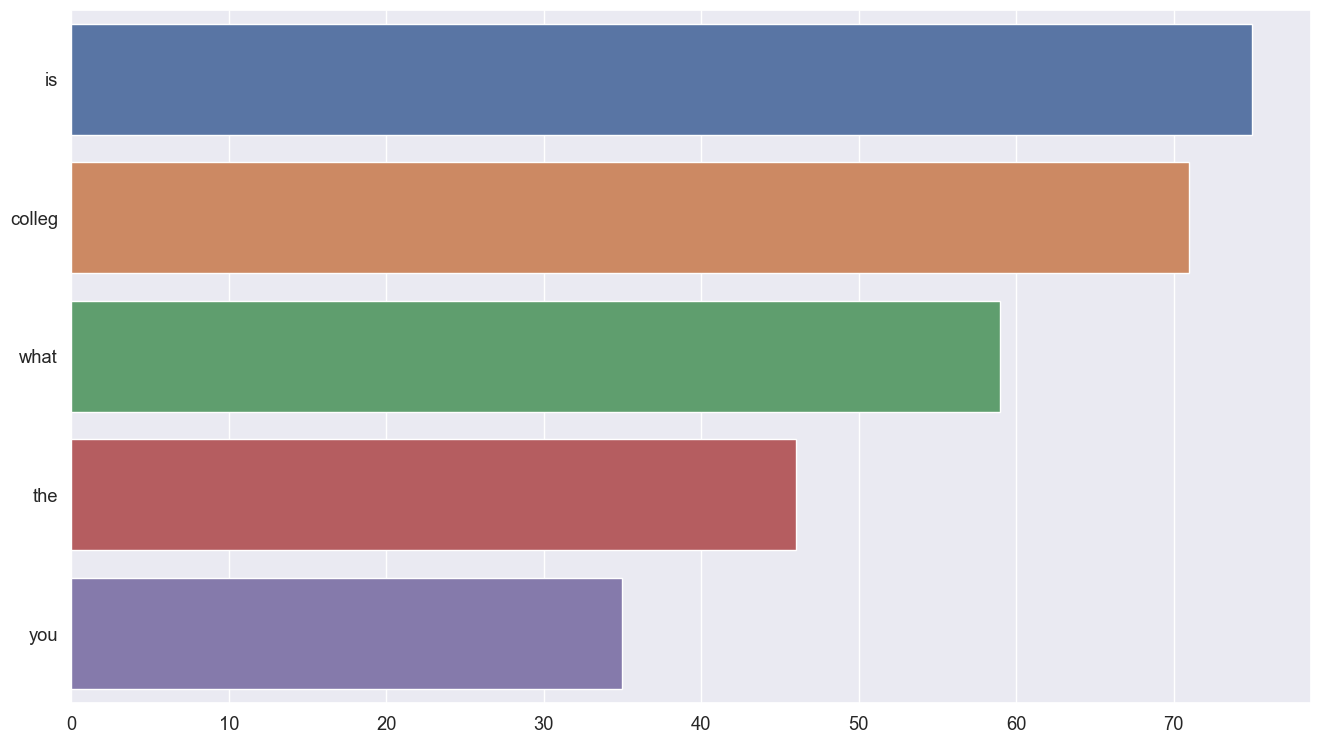

In [38]:
plt.figure(figsize= (16,9))
most_common_uni=get_top_text_ngrams(df.Pattern,5,1)
most_common_uni=dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

# 4 || Data Preprocessing

In [42]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [43]:
labels=df2['Tag'].unique().tolist()

In [44]:
labels=[s.strip() for s in labels]


In [45]:
num_labels=len(labels)

In [46]:
id2label ={id:label for id,label in enumerate(labels)}

In [47]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [48]:
label2id ={label: id for id ,label in enumerate(labels)}

In [49]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [50]:
df2['Tag']

0      greeting
1      greeting
2      greeting
3      greeting
4      greeting
         ...   
400     ragging
401     ragging
402         hod
403         hod
404         hod
Name: Tag, Length: 405, dtype: object

In [51]:
df2['labels']=df2['Tag'].map(lambda x : label2id[x.strip()])

In [52]:
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


# 5 || Split the data into train and test

In [53]:
X=list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [54]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [55]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=123)